# Create a simple Bollinger-band trading strategy and then backtest 
The goal of this notebook is to give an introductry example to what a trading algorithm strategy looks like, and how you could back test such a strategy 
in Python.


In [1]:
!pip install boto3

     |████████████████████████████████| 131 kB 4.4 MB/s eta 0:00:01
     |████████████████████████████████| 7.7 MB 9.0 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 6.2 MB/s eta 0:00:01


In [52]:
# Backtrader plots do not work properly with latest Matplotlib version, so downgrade to this to ensure plots will look like mine
#!pip install --force matplotlib==2.2.4

In [11]:
#import needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import backtrader as bt
from datetime import datetime
import os

from alpha_vantage.foreignexchange import ForeignExchange
import warnings

In [12]:
#Configure certain elements to work best in Jupyterlab
%matplotlib inline
# I add the line below to let the plots take advantage of my Macbook Retina screen, feel free to remove
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.figsize'] = 16,9
pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings('ignore')

## Gather FX Historical Data
I will use Alpha vantage to gather historical data, in order for you to collect data yourself, you'll need to create an free account. visit the website
https://www.alphavantage.co/ and follow the instructions there. <br>
<br>
It's never a good practice to copy your credentials as free text into your code.
I've placed my credentials in a .env file which stays with me locally.

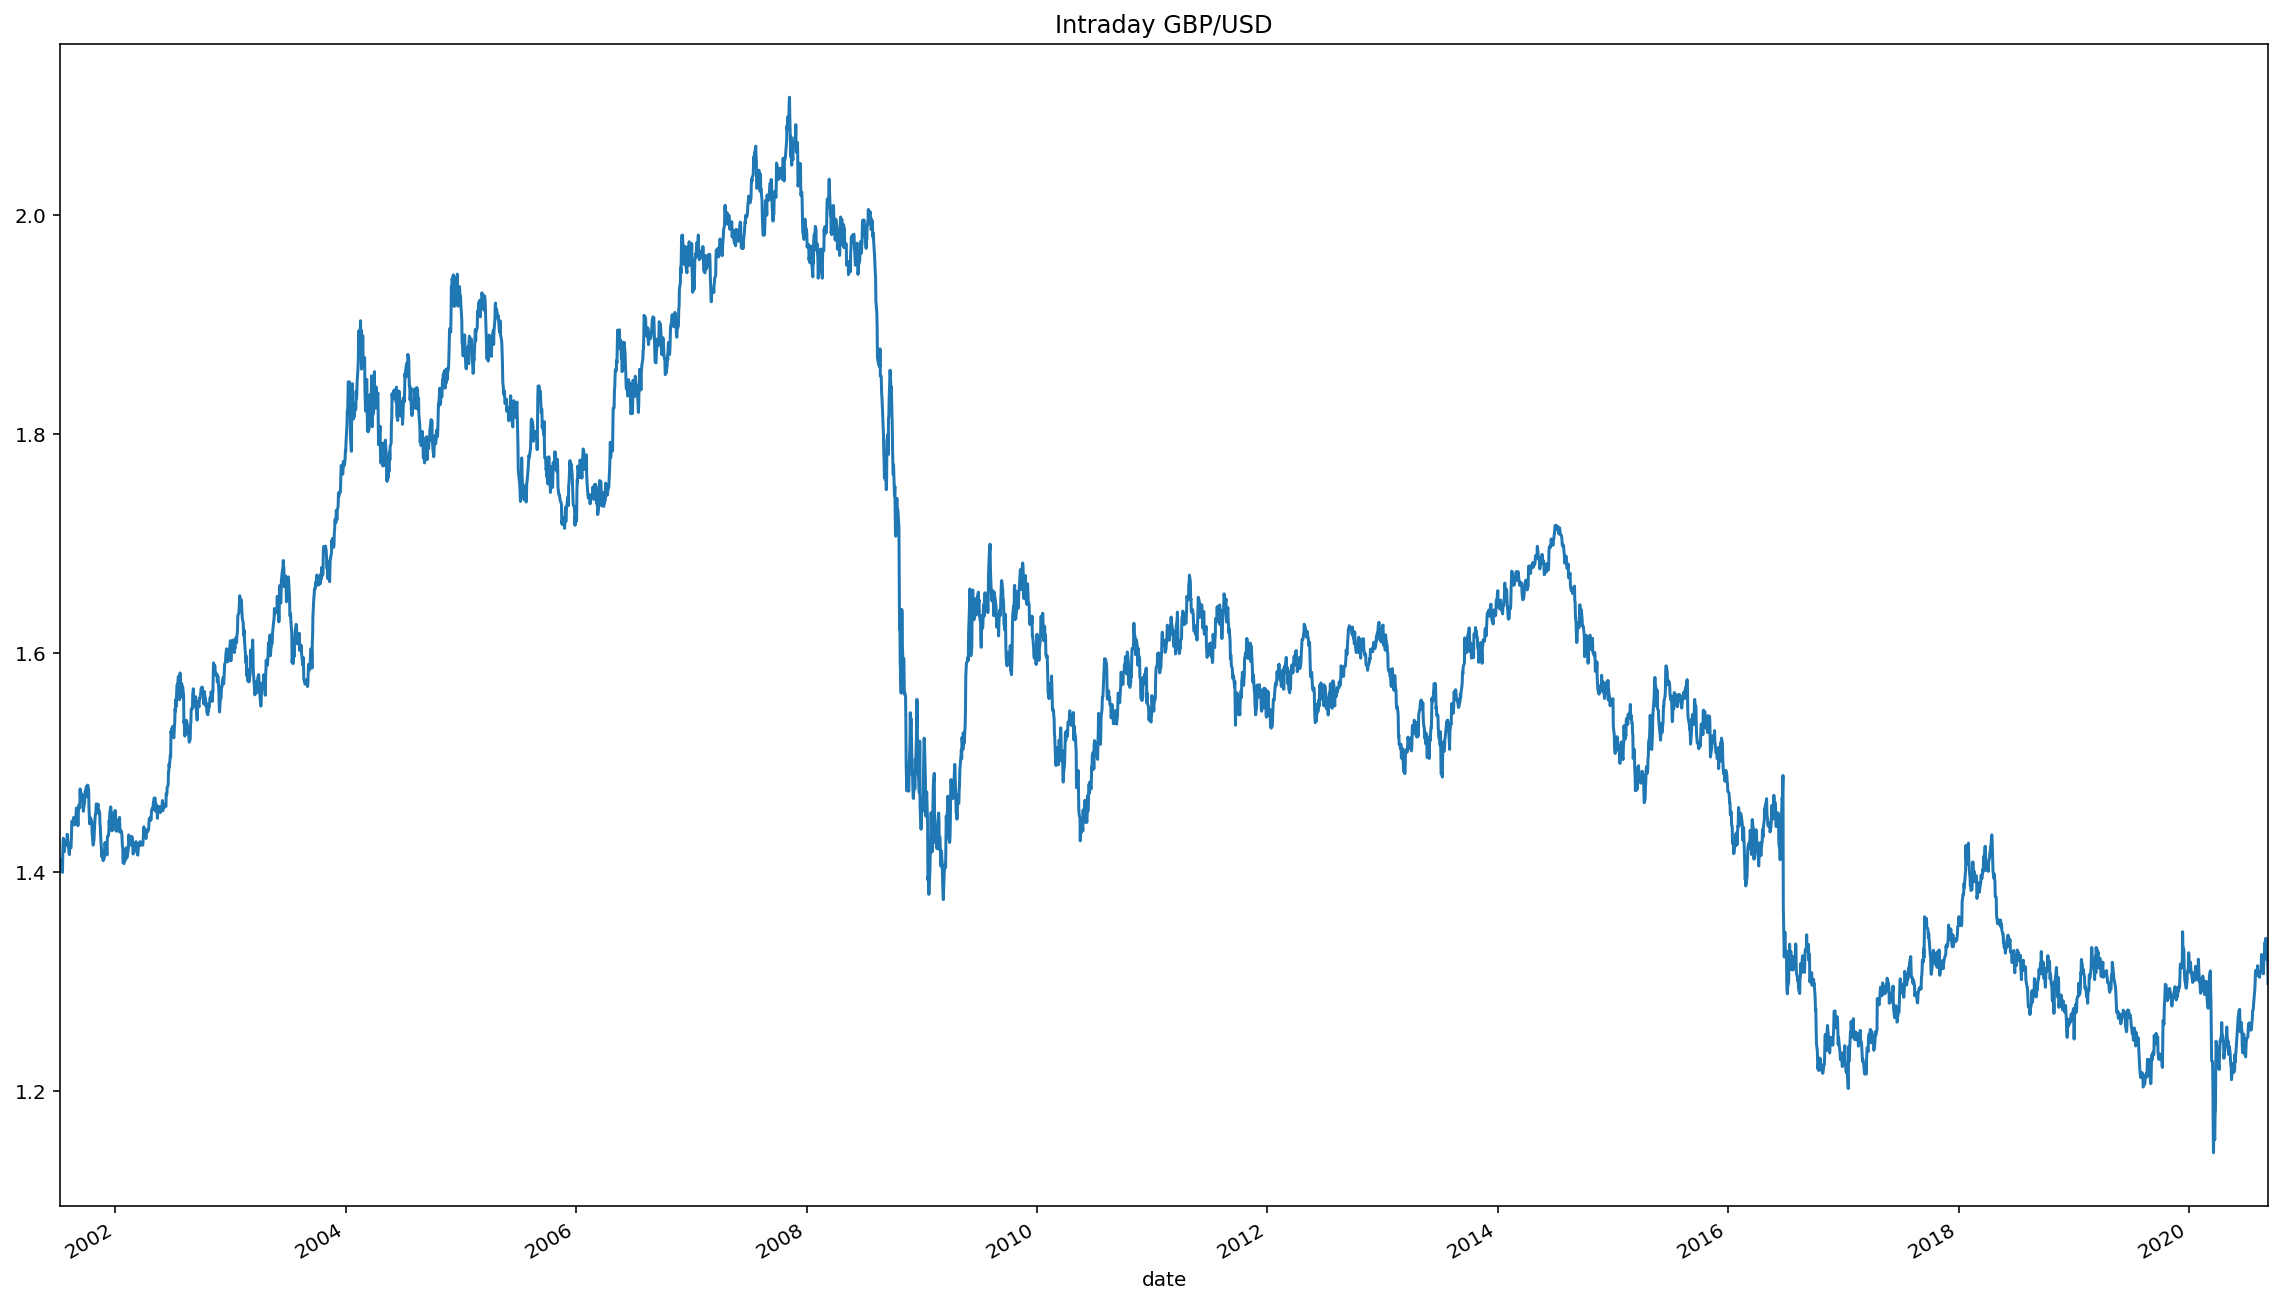

In [54]:
cc = ForeignExchange(key=os.environ['alpha_vantage_token'],output_format='pandas')

# We will retreive daily OHLC prices, Alpha vantage also contains intraday results which are difficult to come by elsewhere

data_df, metadata_df = cc.get_currency_exchange_daily(from_symbol='GBP',to_symbol='USD', outputsize='full')

#Plot what the data looks like

data_df['4. close'].plot()
plt.tight_layout()
plt.title('Intraday GBP/USD')
plt.show()

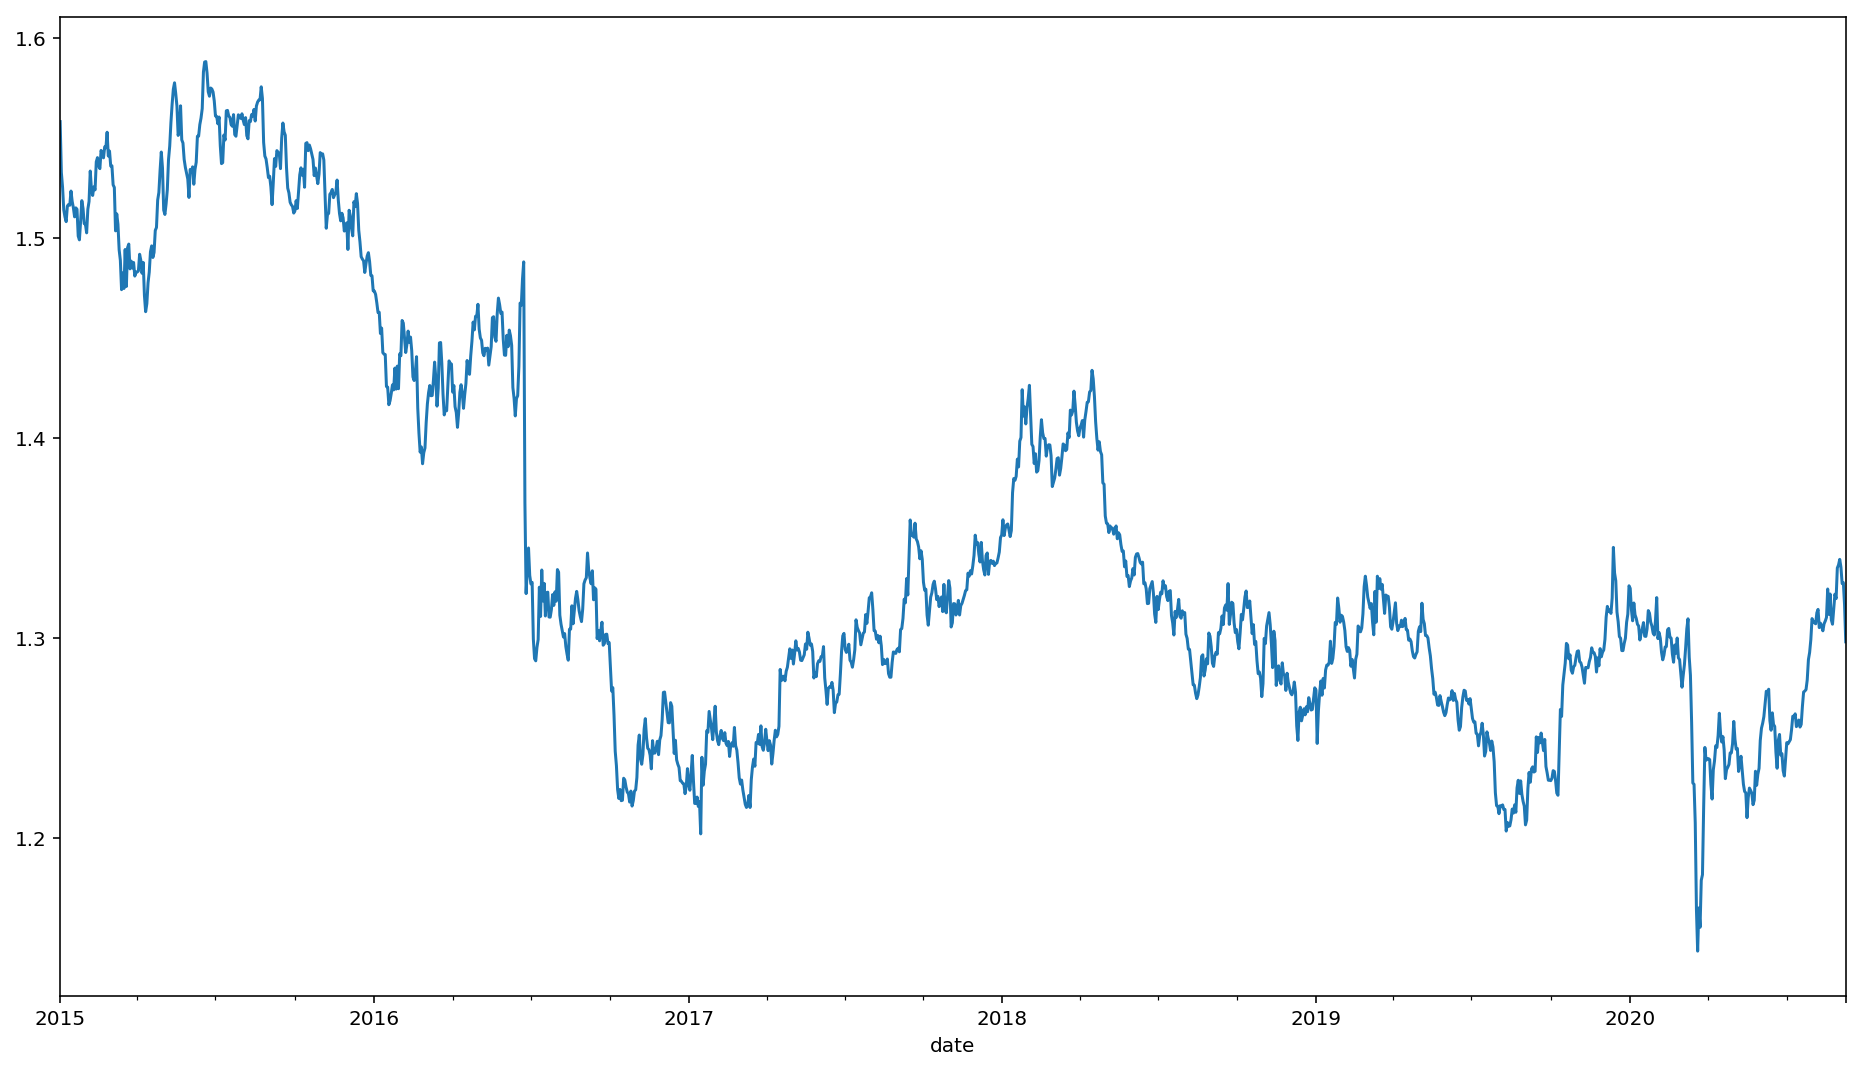

In [55]:
# Let's just look at 2015 onwards 

data_df.sort_index(inplace=True)

data_df = data_df.loc['2015-01-01':]
# Plot the results to ensure everything worked

data_df['4. close'].plot()

In [59]:
# Rename & rearrange the fields so they can be ingested by Backtrader
data_df = data_df.loc[:, ['2. high', '3. low', '1. open', '4. close']]
data_df.columns = ['High', 'Low', 'Open', 'Close']

# Algorithm Strategy Definition 
To do the backtesting, we will use the Backtrader Python package https://www.backtrader.com/. It's a bigger learning curve to compared to other platforms such as Quantopian, but I really enjoy the added flexibility and the fact you can easily integrate with other Python packages/platforms.

In [105]:
class boll_bander(bt.Strategy):
# Set a bollinger band indicator, buy when the price exceeds the lower band, sell when price exceeds higher band.

# Set the parameters for the bollinger band. I chose a 21 day period as that mimics the number of days in a trading month, a smaller standard deviation on the band
# gives more entry & exit opportunities

    params = dict(
        bperiod=21
        ,dev=1.25)
    
    def __init__(self):
        
        #Define Bolligner band
        
        self.boll = bt.ind.BollingerBands(period=self.p.bperiod, devfactor=self.p.dev, plot=True, plotname='Bollinger Band', subplot=False)
        
        #Define cross-over points
        
        self.buysig = bt.indicators.CrossOver(self.data0, self.boll.lines.bot, plotname='buy signal', plot=True)
        self.sellsig = bt.indicators.CrossOver(self.data0, self.boll.lines.top,plotname='sell signal', plot=True)

    def next(self):
        
        if not self.position:  # not in the market
            if self.buysig > 0:  # if fast crosses slow to the upside
                self.order_target_size(target=3000)   # enter long
                
        elif self.sellsig > 0:  # in the market & cross to the downside
            self.order_target_size(target=0)   # close long position 
        

## Run the strategy over the last 5 years 

In [107]:
%%time

cerebro = bt.Cerebro()
data = bt.feeds.PandasData(dataname=data_df)
cerebro.adddata(data)
cerebro.addobserver(bt.observers.Value)
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)
cerebro.addstrategy(boll_bander)
results = cerebro.run()

CPU times: user 460 ms, sys: 9.03 ms, total: 469 ms
Wall time: 476 ms


Sharpe: 0.938
Norm. Annual Return: 1.32%
Max Drawdown: 3.37%


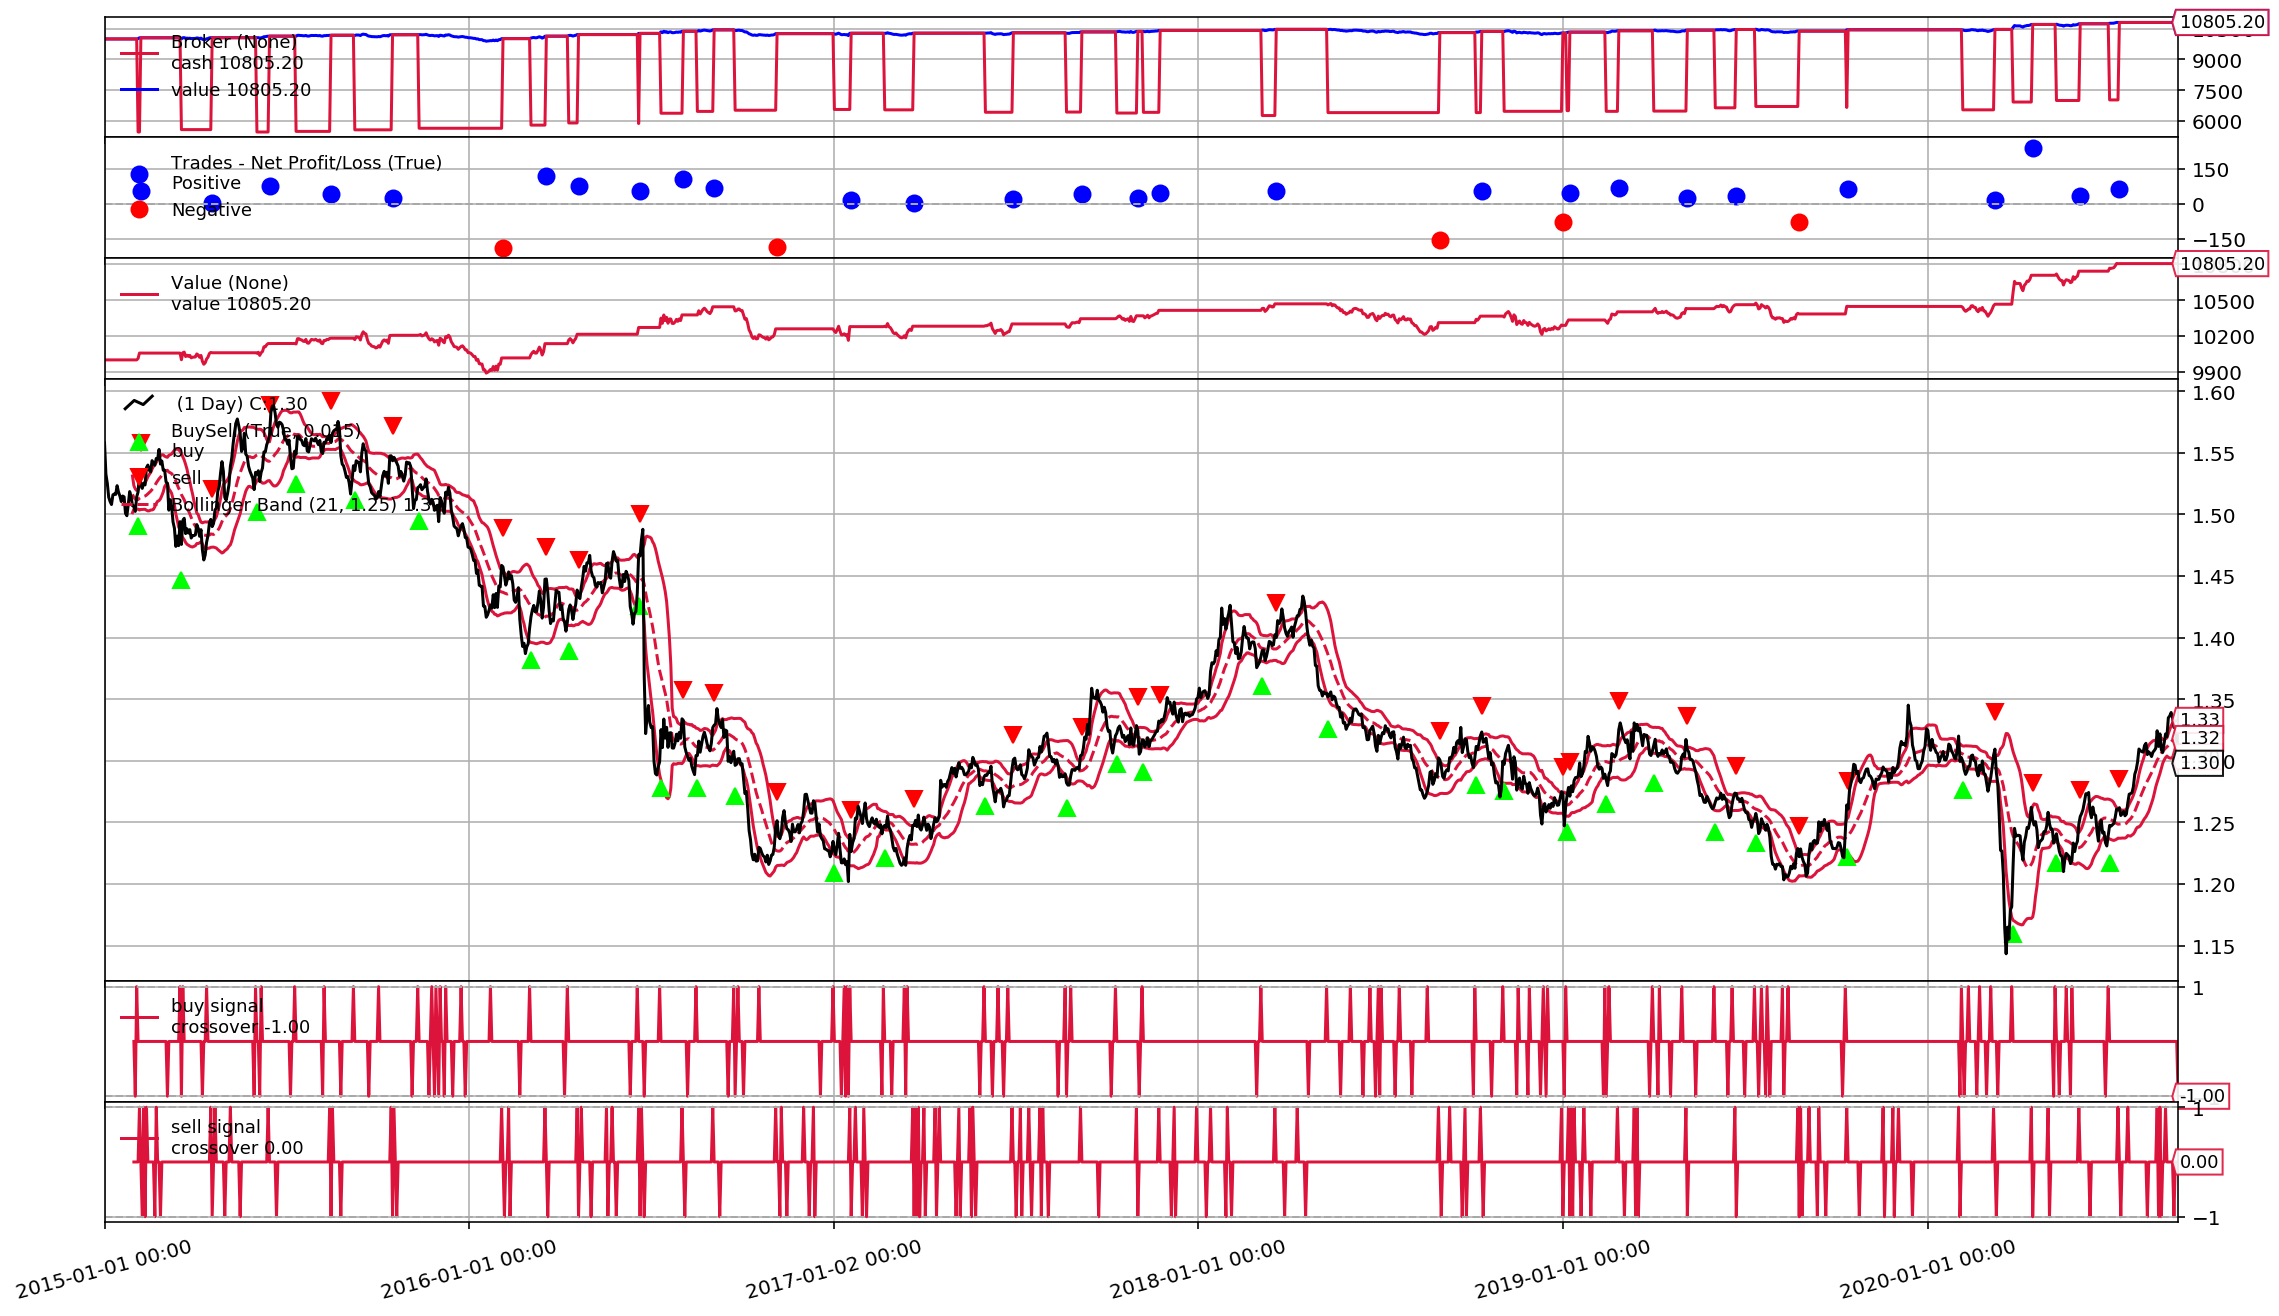

[[<Figure size 1152x648 with 6 Axes>]]

In [108]:
print(f"Sharpe: {results[0].analyzers.sharperatio.get_analysis()['sharperatio']:.3f}")
print(f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%")
print(f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%")
cerebro.plot(iplot=False, volume=False, width=20)

# Results
A 0.938 Sharpe ratio, not bad! Note your results may be slighly different as your data-set will be newer. <br>
It's worth noting that there a few major points to think about with this strategy:

1. The above backtest assumes that we can compute bands at market close and then be able to trade at the exact market open price. In reality we wouldn’t be able to compute bands and trade at the exact open price, but it would be pretty close.

2. The backtest assumes no transaction costs, which would eat away into your profits.

3. Currently, this is a long only strategy, but as you can see there are numerous buy/sell signals that we are not leveraging, so we can turn this into a long/short strategy. Note this will double your number of trades, and therefore transaction costs.